# 訓練DFCT模型

## 引入套件

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import math
import random
import time
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

## 模型定義
### transformer模型

In [4]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
#         if self.src_mask is None or self.src_mask.size(0) != src.size(0):
#             device = src.device
#             mask = self._generate_square_subsequent_mask(src.size(0)).to(device)
#             self.src_mask = mask

        src = self.encoder(src) / math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        return output


class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

### temporal模型定義

In [5]:
class TemporalLSTM(nn.Module):
    def __init__(self, input_size, hid_size):
        super(TemporalLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hid_size)
    
    def forward(self, x):
        output, (h, c) = self.lstm(x)
        return output[:, -1]

class TemporalCNN(nn.Module):
    def __init__(self, input_size, seq_max_len, hid_size):
        super(TemporalCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=1, kernel_size=1, padding=0)
        self.conv3 = nn.Conv1d(in_channels=input_size, out_channels=1, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(in_channels=input_size, out_channels=1, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=input_size, out_channels=1, kernel_size=2, padding=0)
        self.conv4 = nn.Conv1d(in_channels=input_size, out_channels=1, kernel_size=4, padding=1)
        self.W = nn.Linear(5, hid_size)
        self.dense_q = nn.Linear(5, hid_size)
        self.dense_k = nn.Linear(5, hid_size)
        self.dense_v = nn.Linear(5, hid_size)
        self.V = nn.Parameter(torch.randn(hid_size, seq_max_len))
        
    def forward(self, x, pad):
        # x has been transposed
        conv1_x = torch.transpose(self.conv1(x), 1, 2)
        conv3_x = torch.transpose(self.conv3(x), 1, 2)
        conv5_x = torch.transpose(self.conv5(x), 1, 2)
        conv2_in = torch.cat([x, pad[0]], dim=2)
        conv2_x = torch.transpose(self.conv2(conv2_in), 1, 2)
        conv4_x = torch.transpose(self.conv4(torch.cat([x, pad[1]], dim=2)), 1, 2)
        C = torch.cat([conv1_x, conv2_x, conv3_x, conv4_x, conv5_x], dim=2)  # 將所有cnn結果concat -> (batch, seq_len, 5)
        C_w = torch.tanh(torch.sum(self.W(C), dim=1))
        print(self.W(C).shape)
        att = nn.Softmax(dim=1)(torch.matmul(C_w, self.V)).unsqueeze(2)
        output = torch.sum(torch.mul(att, C), dim=1)
        return output

### 主模型定義

In [6]:
class DFTC(nn.Module):
    def __init__(self, embed_size, seq_max_len, hid_size, vocab_n):
        super(DFTC, self).__init__()
        self.TR = TemporalLSTM(1, hid_size)
        self.TC = TemporalCNN(1, seq_max_len, hid_size)
        self.V = nn.Parameter(torch.randn(hid_size, 4))
        self.W_R = nn.Linear(hid_size, hid_size)
        self.W_C = nn.Linear(5, hid_size)
        self.W_H = nn.Linear(embed_size, hid_size)
        self.W_E = nn.Linear(hid_size, hid_size)
        self.dense = nn.Linear(hid_size, 1)
        self.content_model = TransformerModel(vocab_n, embed_size, 4, 256, 2)
#         self.content_dense = nn.Linear(embed_size, hid_size)
        self.V2 = nn.Parameter(torch.randn(126, embed_size, 1))
        self.e_dense = nn.Linear(2 + hid_size, hid_size)
        self.time_emb = nn.Embedding(24, hid_size)
    
    def forward(self, x, x2, pad, content_x, author_f, pub_time):
        TR_x = self.TR(x)
        TC_x = self.TC(torch.transpose(x2, 1, 2), pad)
#         self.W_R(TR_x)
        content_f = self.content_model(content_x)
#         content_f = self.content_dense(content_f)
        content_att = F.softmax(torch.matmul(content_f.unsqueeze(2), self.V2).squeeze(2), dim=1)
        content_f = torch.sum(torch.mul(content_att, content_f), dim=1)
        time_embedding = self.time_emb(pub_time)
        meta_f = self.e_dense(torch.cat([author_f, time_embedding], dim=1))
        h_all = torch.cat([self.W_R(TR_x).unsqueeze(1), self.W_C(TC_x).unsqueeze(1), self.W_H(content_f).unsqueeze(1), self.W_E(meta_f).unsqueeze(1)], dim=1)  # , self.W_H(content_x)
        att = nn.Softmax(dim=1)(torch.matmul(torch.tanh(torch.sum(h_all, dim=1)), self.V)).unsqueeze(2)
        output = torch.sum(torch.mul(att, h_all), dim=1)
        output = nn.LeakyReLU()(self.dense(output))
        return output

## 讀取特徵資料

In [11]:
with open("data.json", "r") as f:
    source_data = json.load(f)

In [12]:
with open("author_feature.json", "r") as f:
    author_feature = json.load(f)

In [13]:
G = nx.read_adjlist("../HatePolitics/HatePolitics_graph07.adjlist")

In [14]:
seq_data = source_data['seq_data']
seq_data2 = source_data['seq_data2']
level = source_data['level']
urls = source_data['urls']
content = source_data['content']
author = source_data['author']
publish_time = source_data['publish_time']

In [15]:
author_feature_list = []
for a in author:
    author_feature_list.append([
        author_feature[a]['avg_comment'],
        author_feature[a]['pop_a'],
    ])

In [16]:
def one_hot(array, num_classes=None):
    enc_data = []
    for e in array:
        enc = np.zeros(num_classes)
        enc[e] = 1.
        enc_data.append(enc)
    return np.array(enc_data)

In [17]:
row_pair = list(zip(seq_data, seq_data2, level, urls, content, author_feature_list, publish_time))
random.seed(1)
random.shuffle(row_pair)
seq_data, seq_data2, level, urls, content, author_feature_list, publish_time = zip(*row_pair)

## 處理文字index

In [18]:
word2idx = {}
for row in content:
    for w in row:
        try:
            word2idx[w]
        except KeyError:
            word2idx[w] = len(word2idx)
word2idx['[UNK]'] = len(word2idx)
word2idx['[PAD]'] = len(word2idx)

In [19]:
data_x = list(zip(seq_data, seq_data2, content, author_feature_list, publish_time))

## train test split

In [20]:
train_x = data_x[:120000]
train_y = level[:120000]
val_x = data_x[120000:144000]
val_y = level[120000:144000]

## 初始化模型

In [21]:
model = DFTC(128, len(max(seq_data)), 64 , len(word2idx))
model.cuda()

DFTC(
  (TR): TemporalLSTM(
    (lstm): LSTM(1, 64)
  )
  (TC): TemporalCNN(
    (conv1): Conv1d(1, 1, kernel_size=(1,), stride=(1,))
    (conv3): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv5): Conv1d(1, 1, kernel_size=(5,), stride=(1,), padding=(2,))
    (conv2): Conv1d(1, 1, kernel_size=(2,), stride=(1,))
    (conv4): Conv1d(1, 1, kernel_size=(4,), stride=(1,), padding=(1,))
    (W): Linear(in_features=5, out_features=64, bias=True)
    (dense_q): Linear(in_features=5, out_features=64, bias=True)
    (dense_k): Linear(in_features=5, out_features=64, bias=True)
    (dense_v): Linear(in_features=5, out_features=64, bias=True)
  )
  (W_R): Linear(in_features=64, out_features=64, bias=True)
  (W_C): Linear(in_features=5, out_features=64, bias=True)
  (W_H): Linear(in_features=128, out_features=64, bias=True)
  (W_E): Linear(in_features=64, out_features=64, bias=True)
  (dense): Linear(in_features=64, out_features=1, bias=True)
  (content_model): TransformerModel(


## 訓練超參數定義

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
start_epoch = 1

In [23]:
train_epoch = 30
batch_size = 200
train_step = len(train_x) / batch_size
val_step = len(val_x) / batch_size

## data generator

In [24]:
def gen_data():
    for i in range(0, len(train_x), batch_size):
        train_seq, train_seq2, train_cont, train_af, train_pubtime = zip(*train_x[i: i+batch_size])
#         train_pubtime = one_hot(train_pubtime, num_classes=24)
        yield (train_seq, train_seq2, train_cont, train_af, train_pubtime), train_y[i: i+batch_size]

In [25]:
def gen_val_data():
    for i in range(0, len(val_x), batch_size):
        val_seq, val_seq2, val_cont, val_af, val_pubtime = zip(*val_x[i: i+batch_size])
#         val_pubtime = one_hot(val_pubtime, num_classes=24)
        yield (val_seq, val_seq2, val_cont, val_af, val_pubtime), val_y[i: i+batch_size]

In [28]:
def gen_eval_data():
    for i in range(0, len(test_x), batch_size):
        test_seq, test_seq2, test_cont, test_af, test_pubtime = zip(*test_x[i: i+batch_size])
        yield (test_seq, test_seq2, test_cont, test_af, test_pubtime), test_y[i: i+batch_size]

## 開始訓練

In [26]:
train_datas = 0
train_loss = 0
val_datas = 0
val_loss = 0
for epoch in range(1):
    model.train()
    t1 = time.time()
    for batch_idx, (data, target) in enumerate(gen_data()):
        seq = torch.tensor(data[0], dtype=torch.float).unsqueeze(2).cuda()
        seq2 = torch.tensor(data[1], dtype=torch.float).unsqueeze(2).cuda()
        cont = []
        for row_cont in data[2]:
            sent = []
            for w in row_cont:
                try:
                    sent.append(word2idx[w])
                except KeyError:
                    sent.append(word2idx['[UNK]'])
            sent += [word2idx['[PAD]']] * (126 - len(sent))
            cont.append(sent)
        cont = torch.tensor(cont, dtype=torch.long).cuda()
        author_tenser = torch.tensor(data[3], dtype=torch.float).cuda()
        pub_time_tensor = torch.tensor(data[4], dtype=torch.long).cuda()
        target = torch.tensor(target, dtype=torch.float).cuda()
        pad2 = torch.zeros(batch_size, 1, 1).cuda()
        pad2.requires_grad = False
        pad4 = torch.zeros(batch_size, 1, 1).cuda()
        pad4.requires_grad = False
        pad = (pad2, pad4)
        optimizer.zero_grad()
        output = model(seq, seq2, pad, cont, author_tenser, pub_time_tensor)
#         print(output.shape)
#         print(target.shape)
        loss = torch.nn.functional.mse_loss(output, target.unsqueeze(-1))
        train_loss += loss.item()
        train_datas += batch_size
        loss.backward()
        optimizer.step()
    t2 = time.time()
    avg_loss = train_loss / train_datas
    print('Train Epoch: {} [{:2d}/{} ({:.1f}%)]\tLoss: {:.6f}\t, Time: {:.5f}'.format(
        epoch, batch_idx+1, train_step,
        100. * batch_idx+1 / train_step, avg_loss, t2-t1))
    t1 = time.time()
    model.eval()
    t1 = time.time()
    for batch_idx, (data, target) in enumerate(gen_val_data()):
        seq = torch.tensor(data[0], dtype=torch.float).unsqueeze(2).cuda()
        seq2 = torch.tensor(data[1], dtype=torch.float).unsqueeze(2).cuda()
        cont = []
        for row_cont in data[2]:
            sent = []
            for w in row_cont:
                try:
                    sent.append(word2idx[w])
                except KeyError:
                    sent.append(word2idx['[UNK]'])
            sent += [word2idx['[PAD]']] * (126 - len(sent))
            cont.append(sent)
        cont = torch.tensor(cont, dtype=torch.long).cuda()
        author_tenser = torch.tensor(data[3], dtype=torch.float).cuda()
        pub_time_tensor = torch.tensor(data[4], dtype=torch.long).cuda()
        target = torch.tensor(target, dtype=torch.float).cuda()
        pad2 = torch.zeros(batch_size, 1, 1).cuda()
        pad2.requires_grad = False
        pad4 = torch.zeros(batch_size, 1, 1).cuda()
        pad4.requires_grad = False
        pad = (pad2, pad4)
        output = model(seq, seq2, pad, cont, author_tenser, pub_time_tensor)
        loss = torch.nn.functional.mse_loss(output, target.unsqueeze(-1))
        val_loss += loss.item()
        val_datas += batch_size
    t2 = time.time()
    avg_loss = val_loss / val_datas
    print('Valid Epoch: {} [{:2d}/{} ({}%)] \tLoss: {:.6f}\t, Time: {:.5f}'.format(
        epoch, batch_idx+1, val_step,
        100. * batch_idx+1 / val_step, avg_loss, t2-t1))

Train Epoch: 0 [600/600.0 (59900.0%)]	Loss: 15.079577	, Time: 78.51826


Valid Epoch: 0 [120/120.0 (11900.008333333333%)] 	Loss: 15.106201	, Time: 5.91668
其他省略...

儲存模型

In [53]:
torch.save({
    "epoch": train_epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict()
}, "DFTC_{}.ckpt".format(train_epoch))

## 測試模型

In [27]:
test_x = data_x[120000:144000]
test_y = level[120000:144000]

In [29]:
eval_step = len(test_x) / batch_size

In [30]:
model.eval()
t1 = time.time()
correct = 0
train_datas = 0
train_loss = 0
result = []
for batch_idx, (data, target) in enumerate(gen_eval_data()):
    seq = torch.tensor(data[0], dtype=torch.float).unsqueeze(2).cuda()
    seq2 = torch.tensor(data[1], dtype=torch.float).unsqueeze(2).cuda()
    cont = []
    for row_cont in data[2]:
        sent = []
        for w in row_cont:
            try:
                sent.append(word2idx[w])
            except KeyError:
                sent.append(word2idx['[UNK]'])
        sent += [word2idx['[PAD]']] * (126 - len(sent))
        cont.append(sent)
    cont = torch.tensor(cont, dtype=torch.long).cuda()
    author_tenser = torch.tensor(data[3], dtype=torch.float).cuda()
    pub_time_tensor = torch.tensor(data[4], dtype=torch.long).cuda()
    target = torch.tensor(target, dtype=torch.float).cuda()
    pad2 = torch.zeros(batch_size, 1, 1).cuda()
    pad2.requires_grad = False
    pad4 = torch.zeros(batch_size, 1, 1).cuda()
    pad4.requires_grad = False
    pad = (pad2, pad4)
    optimizer.zero_grad()
    output = model(seq, seq2, pad, cont, author_tenser, pub_time_tensor)
    loss = torch.nn.functional.mse_loss(output, target.unsqueeze(-1))
    train_loss += loss.item()
    train_datas += batch_size
    result.append(output.cpu().detach().numpy())
    if batch_idx % 10 == 0 and batch_idx != 0:
        t2 = time.time()
        avg_loss = train_loss / train_datas
        print('Prdict process: [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t, Time: {}'.format(
            epoch, batch_idx, eval_step,
            100. * batch_idx / eval_step, avg_loss, t2-t1))
        t1 = t2

Prdict process: [10/120.0 (8%)]	Loss: 3.978817	, Time: 0.17616057395935059
Prdict process: [20/120.0 (17%)]	Loss: 4.552621	, Time: 0.15739154815673828
Prdict process: [30/120.0 (25%)]	Loss: 3.746260	, Time: 0.15983963012695312
Prdict process: [40/120.0 (33%)]	Loss: 3.416740	, Time: 0.15832924842834473
Prdict process: [50/120.0 (42%)]	Loss: 2.863694	, Time: 0.15861868858337402
Prdict process: [60/120.0 (50%)]	Loss: 2.517972	, Time: 0.15877771377563477
Prdict process: [70/120.0 (58%)]	Loss: 2.292174	, Time: 0.1608872413635254
Prdict process: [80/120.0 (67%)]	Loss: 2.212564	, Time: 0.15871095657348633
Prdict process: [90/120.0 (75%)]	Loss: 2.284500	, Time: 0.15883469581604004
Prdict process: [100/120.0 (83%)]	Loss: 2.270953	, Time: 0.15856313705444336
Prdict process: [110/120.0 (92%)]	Loss: 2.230916	, Time: 0.158674955368042


跑預測

In [31]:
predict_result = np.array(result)

In [33]:
predict_result = predict_result.reshape(predict_result.shape[0] * predict_result.shape[1], 1).astype(np.int16)

In [39]:
predict = []
target = []
feature = []
for i, (p, t, x) in enumerate(zip(predict_result, test_y, test_x)):
    predict.append(p[0])
    target.append(t)
    feature.append(x[0][-1])

In [40]:
df = pd.DataFrame({"Predict": predict, "Ground True": target, "URL": urls[120000:144000], "Num": feature})

## 模型預測測試資料觀察

In [41]:
df

,Ground True,Num,Predict,URL
0,9,8,11,M.1596947250.A.0DF
1,6,4,7,M.1594385250.A.B17
2,19,16,20,M.1592922962.A.A5F
3,47,33,41,M.1592992689.A.DEE
4,6,2,6,M.1591206331.A.C5A
5,15,14,16,M.1594351603.A.F78
6,746,326,712,M.1596154881.A.ABE
7,23,19,24,M.1588833977.A.D8A
8,22,19,20,M.1594274163.A.A9B
9,30,28,33,M.1591679483.A.5F5


In [40]:
df['Rate'] = df['Ground True'] / df['Predict']

In [41]:
error_rate = 0.3

## 預測結果視覺化

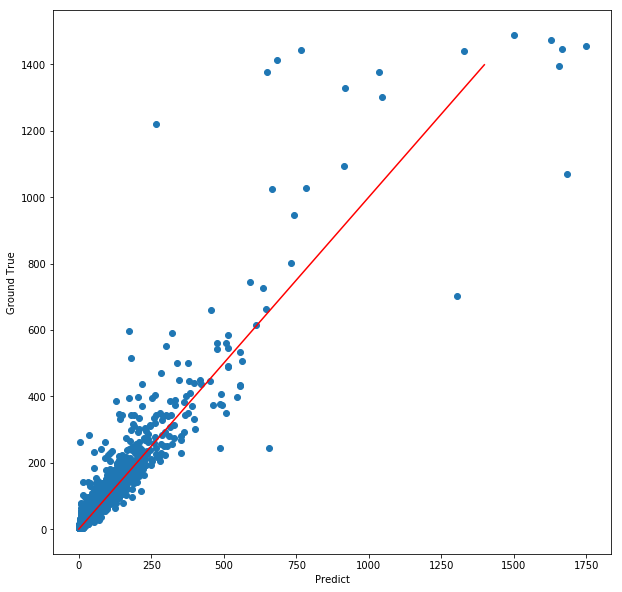

In [42]:
plt.figure(figsize=(10, 10))
plt.scatter(df['Predict'], df['Ground True'])
plt.plot([i for i in range(1400)], 'r')
plt.xlabel("Predict")
plt.ylabel("Ground True")
plt.show()

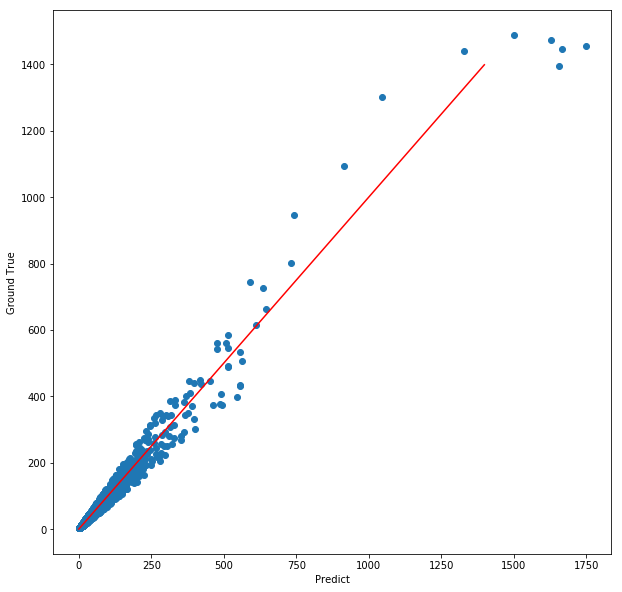

In [43]:
plt.figure(figsize=(10, 10))
plt.scatter(df.loc[(df['Rate'] > (1-error_rate)) & (df['Rate'] < (1+error_rate))]["Predict"],
            df.loc[(df['Rate'] > (1-error_rate)) & (df['Rate'] < (1+error_rate))]['Ground True'])
plt.plot([i for i in range(1400)], 'r')
plt.xlabel("Predict")
plt.ylabel("Ground True")
plt.show()

## Classification Report

In [45]:
def to_category(row):
    if row < 27:
        return 0
    elif 27 <= row <= 175:
        return 1
    elif row > 175:
        return 2

In [46]:
df['Predict_label'] = df['Predict'].apply(to_category)

In [47]:
df['Target_label'] = df['Ground True'].apply(to_category)

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
import itertools

In [50]:
print(classification_report(df['Target_label'].values, df['Predict_label'].values))

             precision    recall  f1-score   support

          0       0.96      0.97      0.97     16740
          1       0.91      0.91      0.91      6943
          2       0.86      0.77      0.81       317

avg / total       0.95      0.95      0.95     24000



## Confusion matrix

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[16220   520     0]
 [  603  6302    38]
 [    2    72   243]]


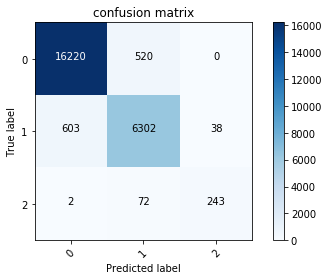

In [52]:
plt.figure()
cnf_matrix = confusion_matrix(df['Target_label'].values, df['Predict_label'].values)
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2], normalize=False, title='confusion matrix')
plt.show()